# Task III - Quantum Convolutional Neural Network (QCNN)

# 1. Introduction

### Goal

- Perform **binary classification** on particle physics data to **separate electrons and photons**

### On the theory and motivation behind QCNN

- Classically, a CNN consists of a sequence of image processing layers. Each layer is made up of a **convolution layer** and a **pooling layer**. The main purpose of a convolution layer is to extract features (to form a feature map) from the input image through the application of filters (usually 3x3) that scan through the image pixels. Whereas a pooling layer down samples the resulting feature map from the convolution layer by summarizing its features. Once the feature map size becomes sufficiently small after repeated appliation of convolution and pooling, the resultant image is passed to a **fully-connected layer** to compute the final output for classification. 

- In order to implement a quantum version of CNN, we first need a way to **encode classical image into the quantum state of a quantum circuit**. For this, Farhi (https://arxiv.org/pdf/1802.06002.pdf) et al. proposed representing each pixel with a qubit, with the state depending on the value of the pixel. Therefore for an image of dimension (wxh), a quantum circuit with a **grid qubit layout of the same shape** can be used **to encode the image**. Then we must device ways to convert the convolution layer, pooling layer and fully-connected layer into their quantum circuit representations. Here, we'll base on the implementation from Cong (https://arxiv.org/pdf/1810.03787.pdf) which uses **parameterised quantum circuits (PQCs) constructed with a particular set of gate operations for each layer**. The values of the parameters in the PQCs therefore represents the weights in the corresponding classical neural network layers. We will discuss how the layers are constructed in the later part of this task. 

### On the packages used

- In this task, we wil be using the `quple` package for **parameterised quantum circuit (PQC) construction**. `quple` is a package developed by myself in last year's GSoC project related to Varational Quantum Classifier (VQC) and has been extended to more machine learning algorithms. The package is based on the Google `cirq` and `tensorflow_quantum` library.

- For the actual model construction and training, we will be using the Google `tensorflow_quantum` library. It is responsible for **constructing the neural network layers, loss function and optimization**.


# 2. Data Preprocessing

In [1]:
# load some packages just to start
import operator
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

### Load Input

The input dataset:

- Contains 100 samples for training and another 100 for testing
- Each sample is a 32x32 image containing the particles' energy

In [2]:
data = dict(np.load('../data/electron-photon.npz'))
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
print('Min(Max) of training sample: {}({:.4f})'.format(np.min(x_train), np.max(x_train)))
print('Min(Max) of test sample: {}({:.4f})'.format(np.min(x_test), np.max(x_test)))
print('Dimension of training sample: {}'.format(x_train.shape))
print('Dimension of test sample: {}'.format(x_test.shape))

Min(Max) of training sample: 0.0(1.4274)
Min(Max) of test sample: 0.0(1.3920)
Dimension of training sample: (100, 32, 32)
Dimension of test sample: (100, 32, 32)


**Some observations**:

Here we observe that the **image size is (32 x 32) = 1024 datapoints**. If we are to encode each pixel data into one qubit just like the ordinary way, this would require 1024 qubits which is way beyond the capability of simulators (and of course the currently NISQ computer hardware)

Therefore, we need to make some smart decisions to trim down and compress the image into a more useful representation that can fit the size of an ordinary quantum simulator circuit (which should be less than 20). 

### Visualize Images of Energy Distributions

In [3]:
particle_label_map = {
    0: 'photon',
    1: 'electron'
}
def vitualize_image(img, labels):
    fig = plt.figure(figsize=(20,40))
    columns = 7
    rows = 15
    plt.subplots_adjust(hspace=0.3)
    for i in range(img.shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Image {}: {}'.format(i+1, particle_label_map[labels[i]]))
        plt.imshow(img[i])
    return plt

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

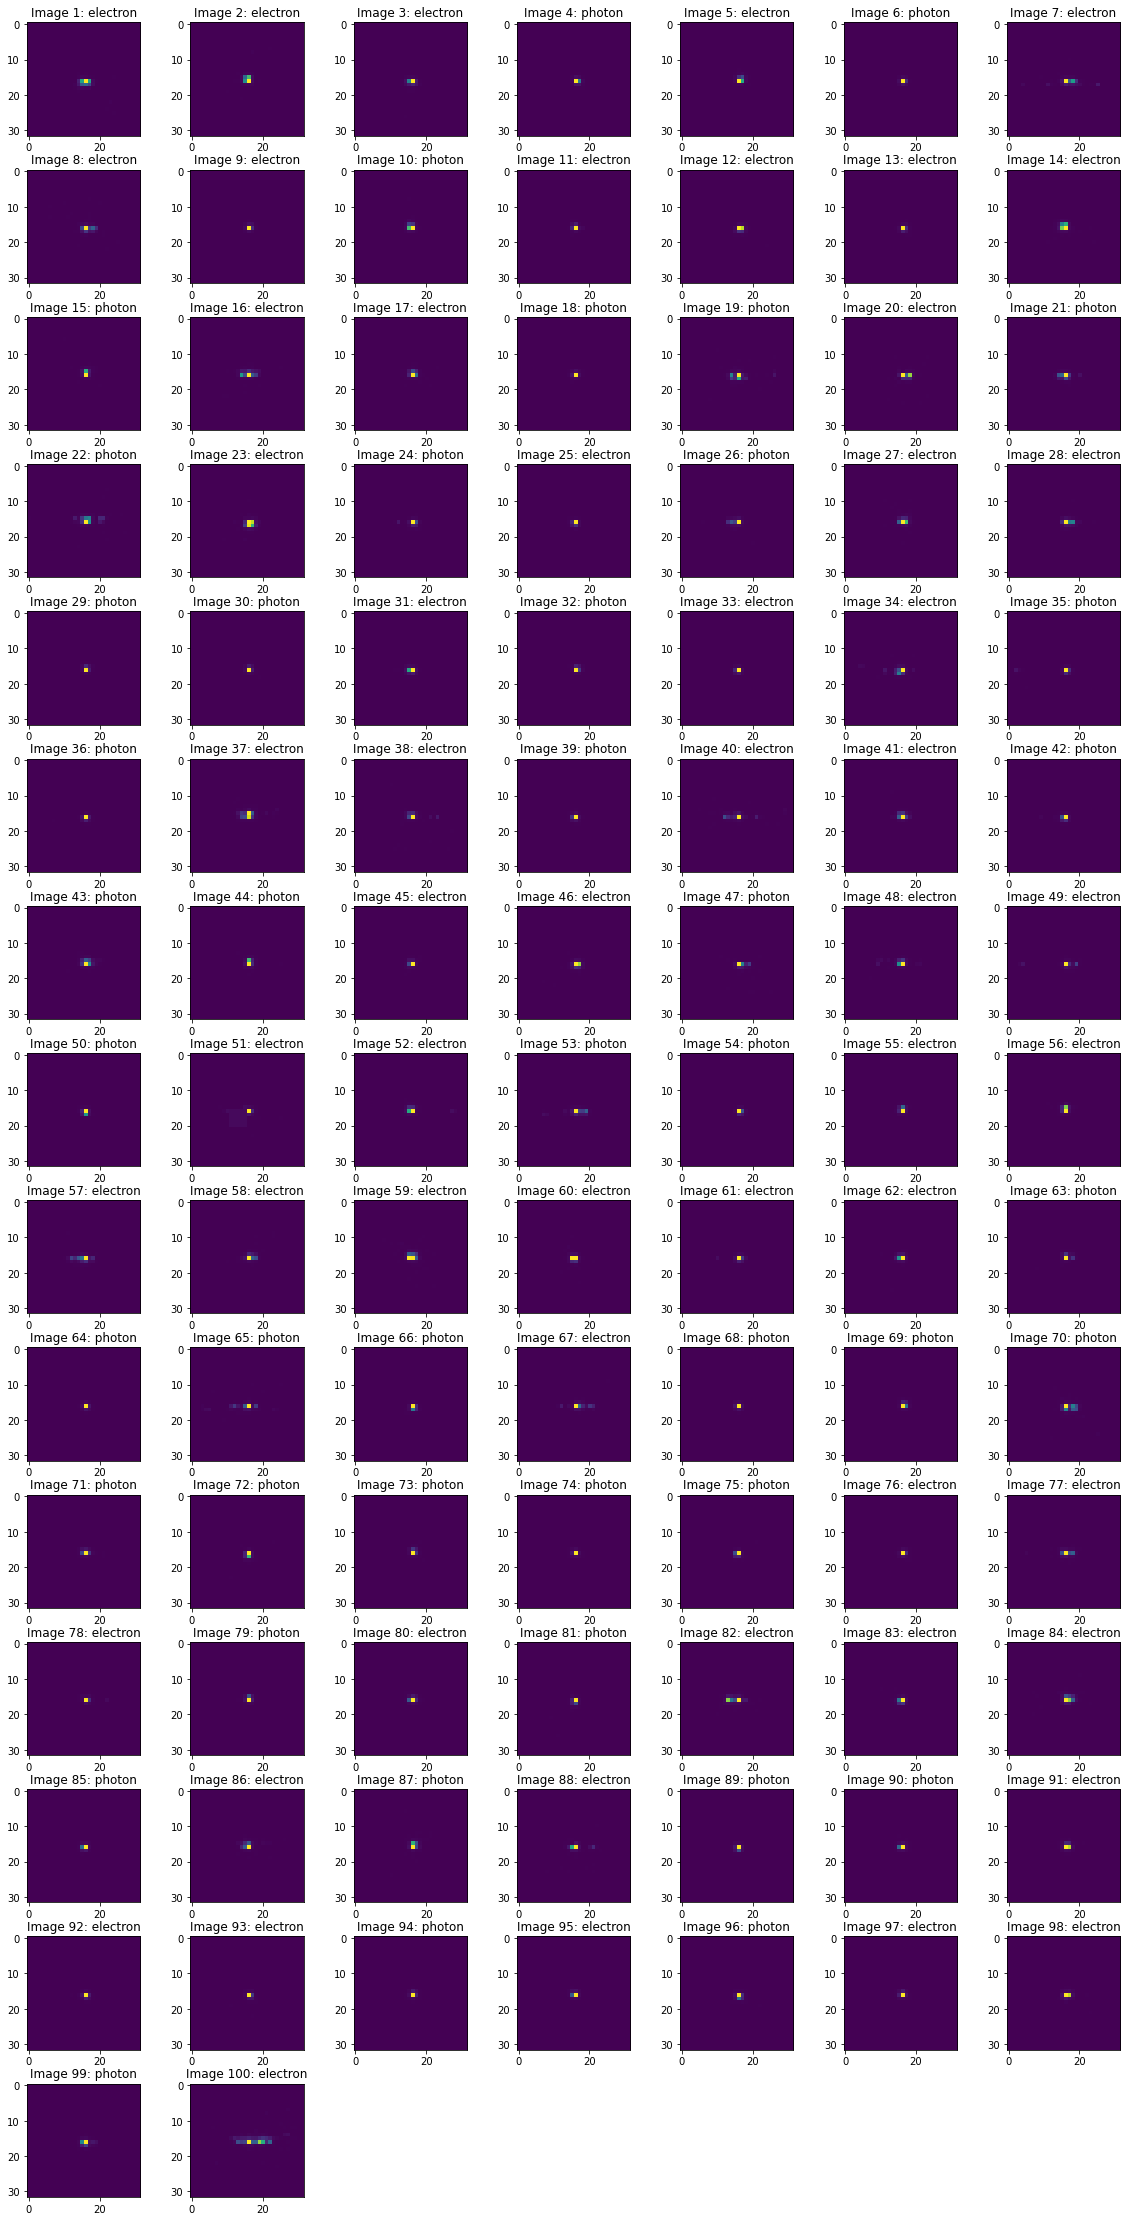

In [4]:
# display the images for the training samples
vitualize_image(x_train, y_train)

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

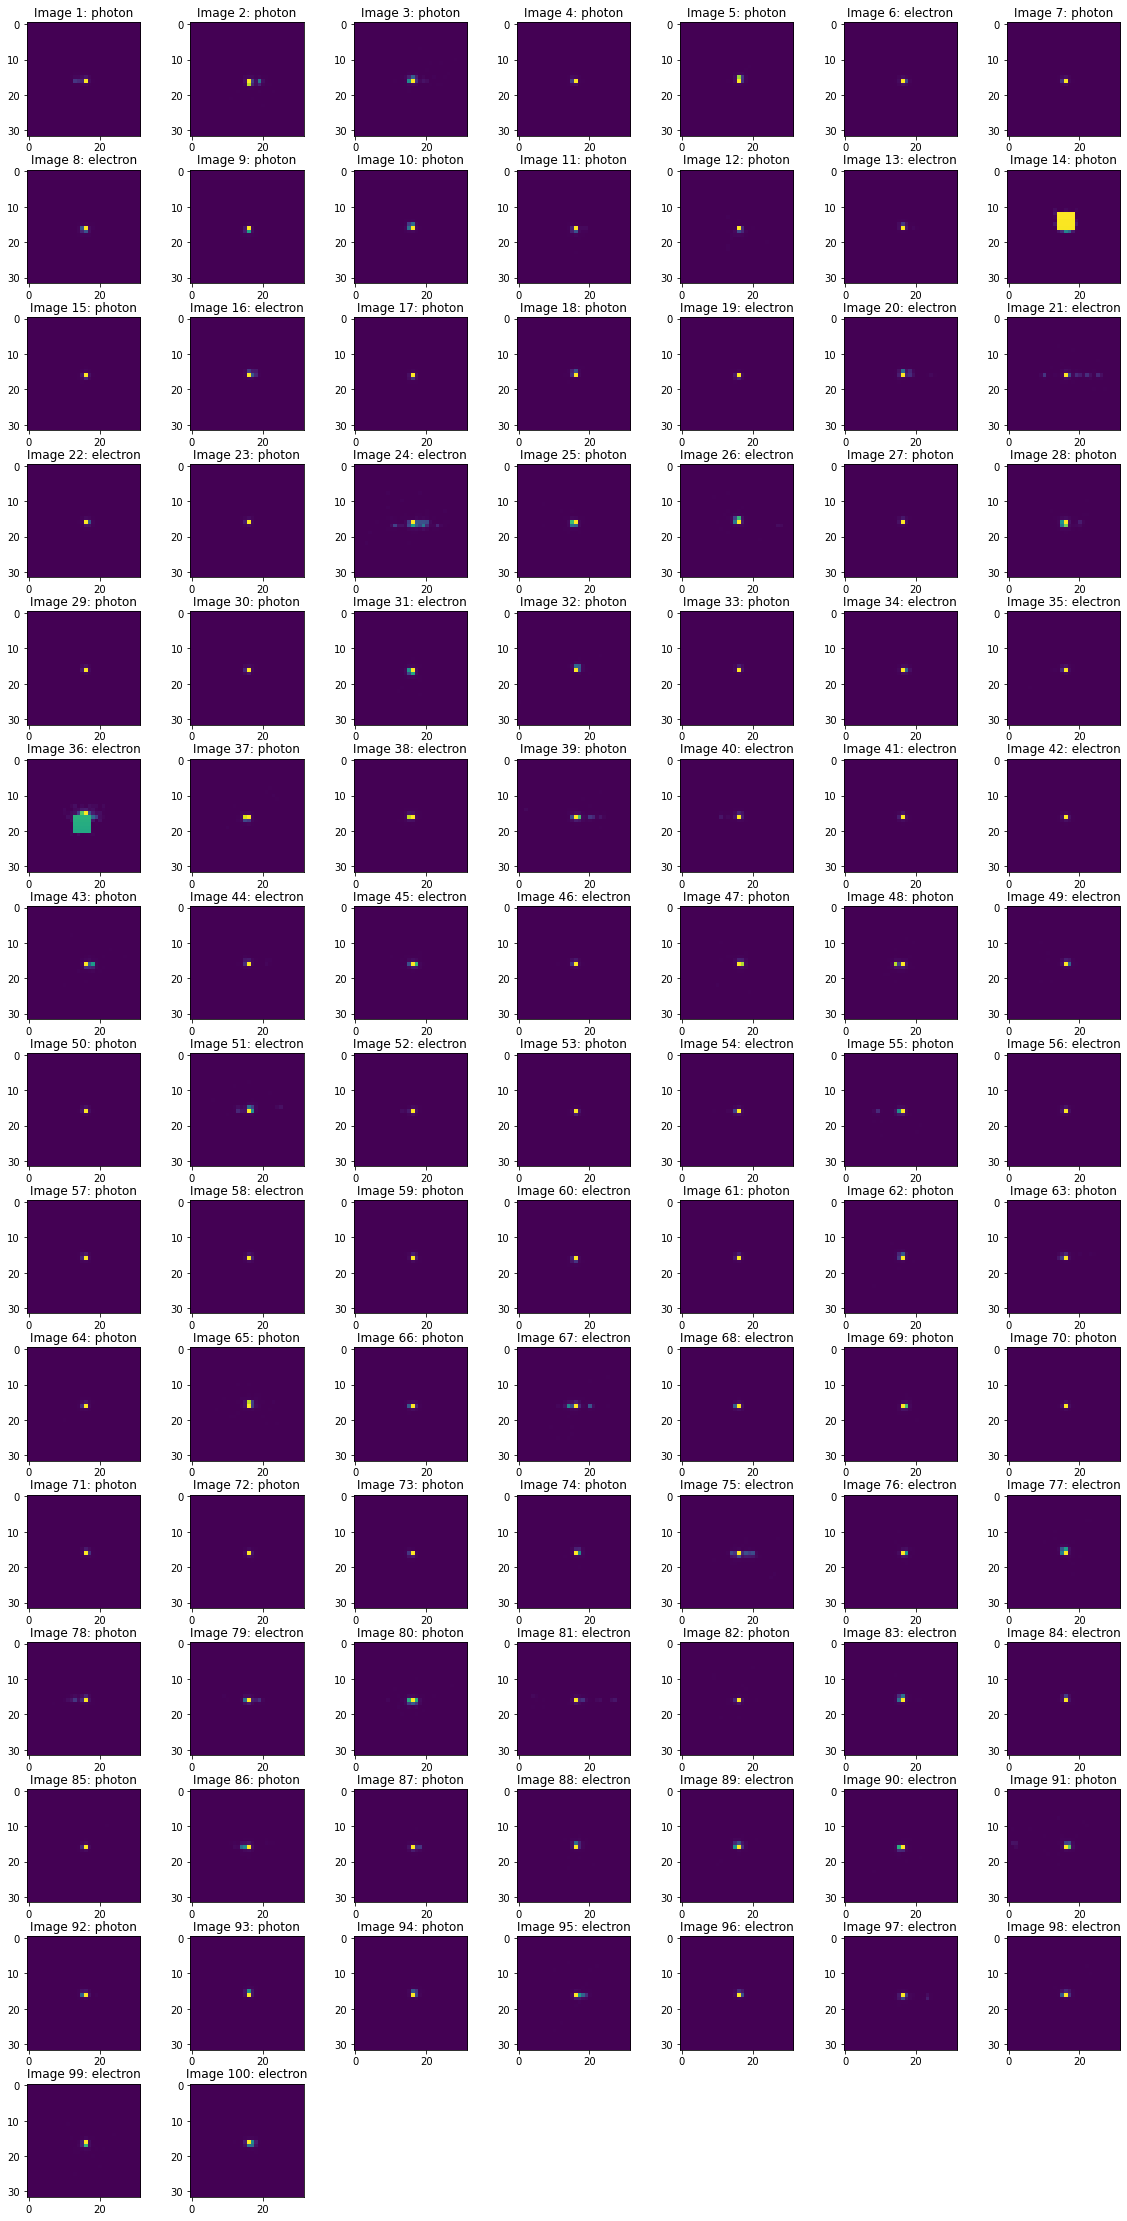

In [5]:
# display the images for the test samples
vitualize_image(x_test, y_test)

## 2.1 Image Cropping

Note that the image is
1. Mostly empty except at the center
2. All jets are centered and aligned in the same direction (horizontally)

That means we can crop out the central region of the image without losing much information about the jet. And we don't need to rotate the image.

So by inspection, it should be safe to **crop out the central (8x8) grid**.

In [6]:
def crop_image(img, dimension):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, dimension))
    end = tuple(map(operator.add, start, dimension))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [7]:
crop_size = (8, 8)
x_train_cropped = np.array([crop_image(i, crop_size) for i in x_train])
x_test_cropped = np.array([crop_image(i, crop_size) for i in x_test])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

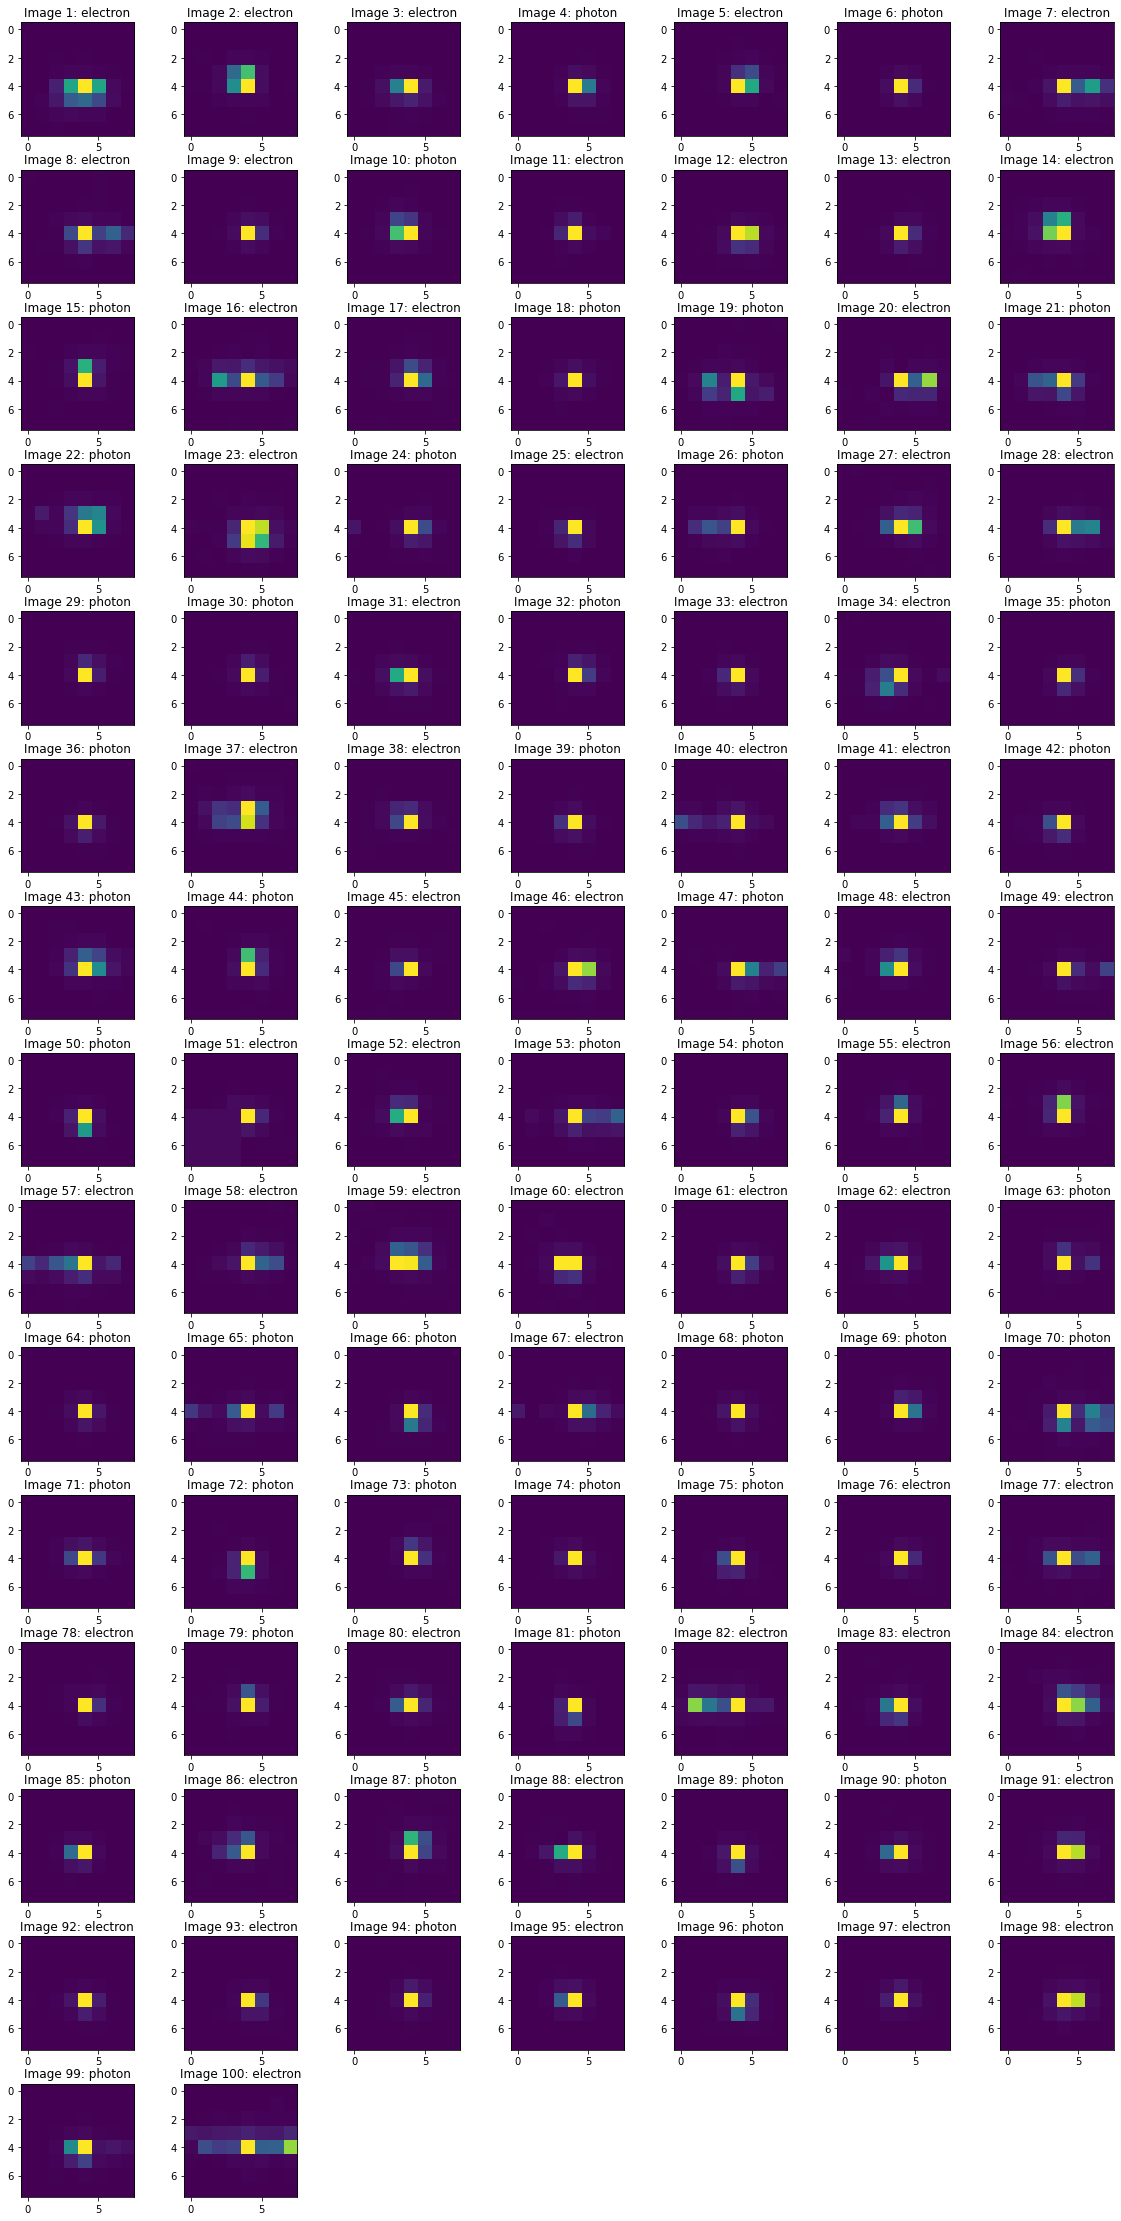

In [8]:
# let's visualize the image again to make sure we are good
vitualize_image(x_train_cropped, y_train)

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

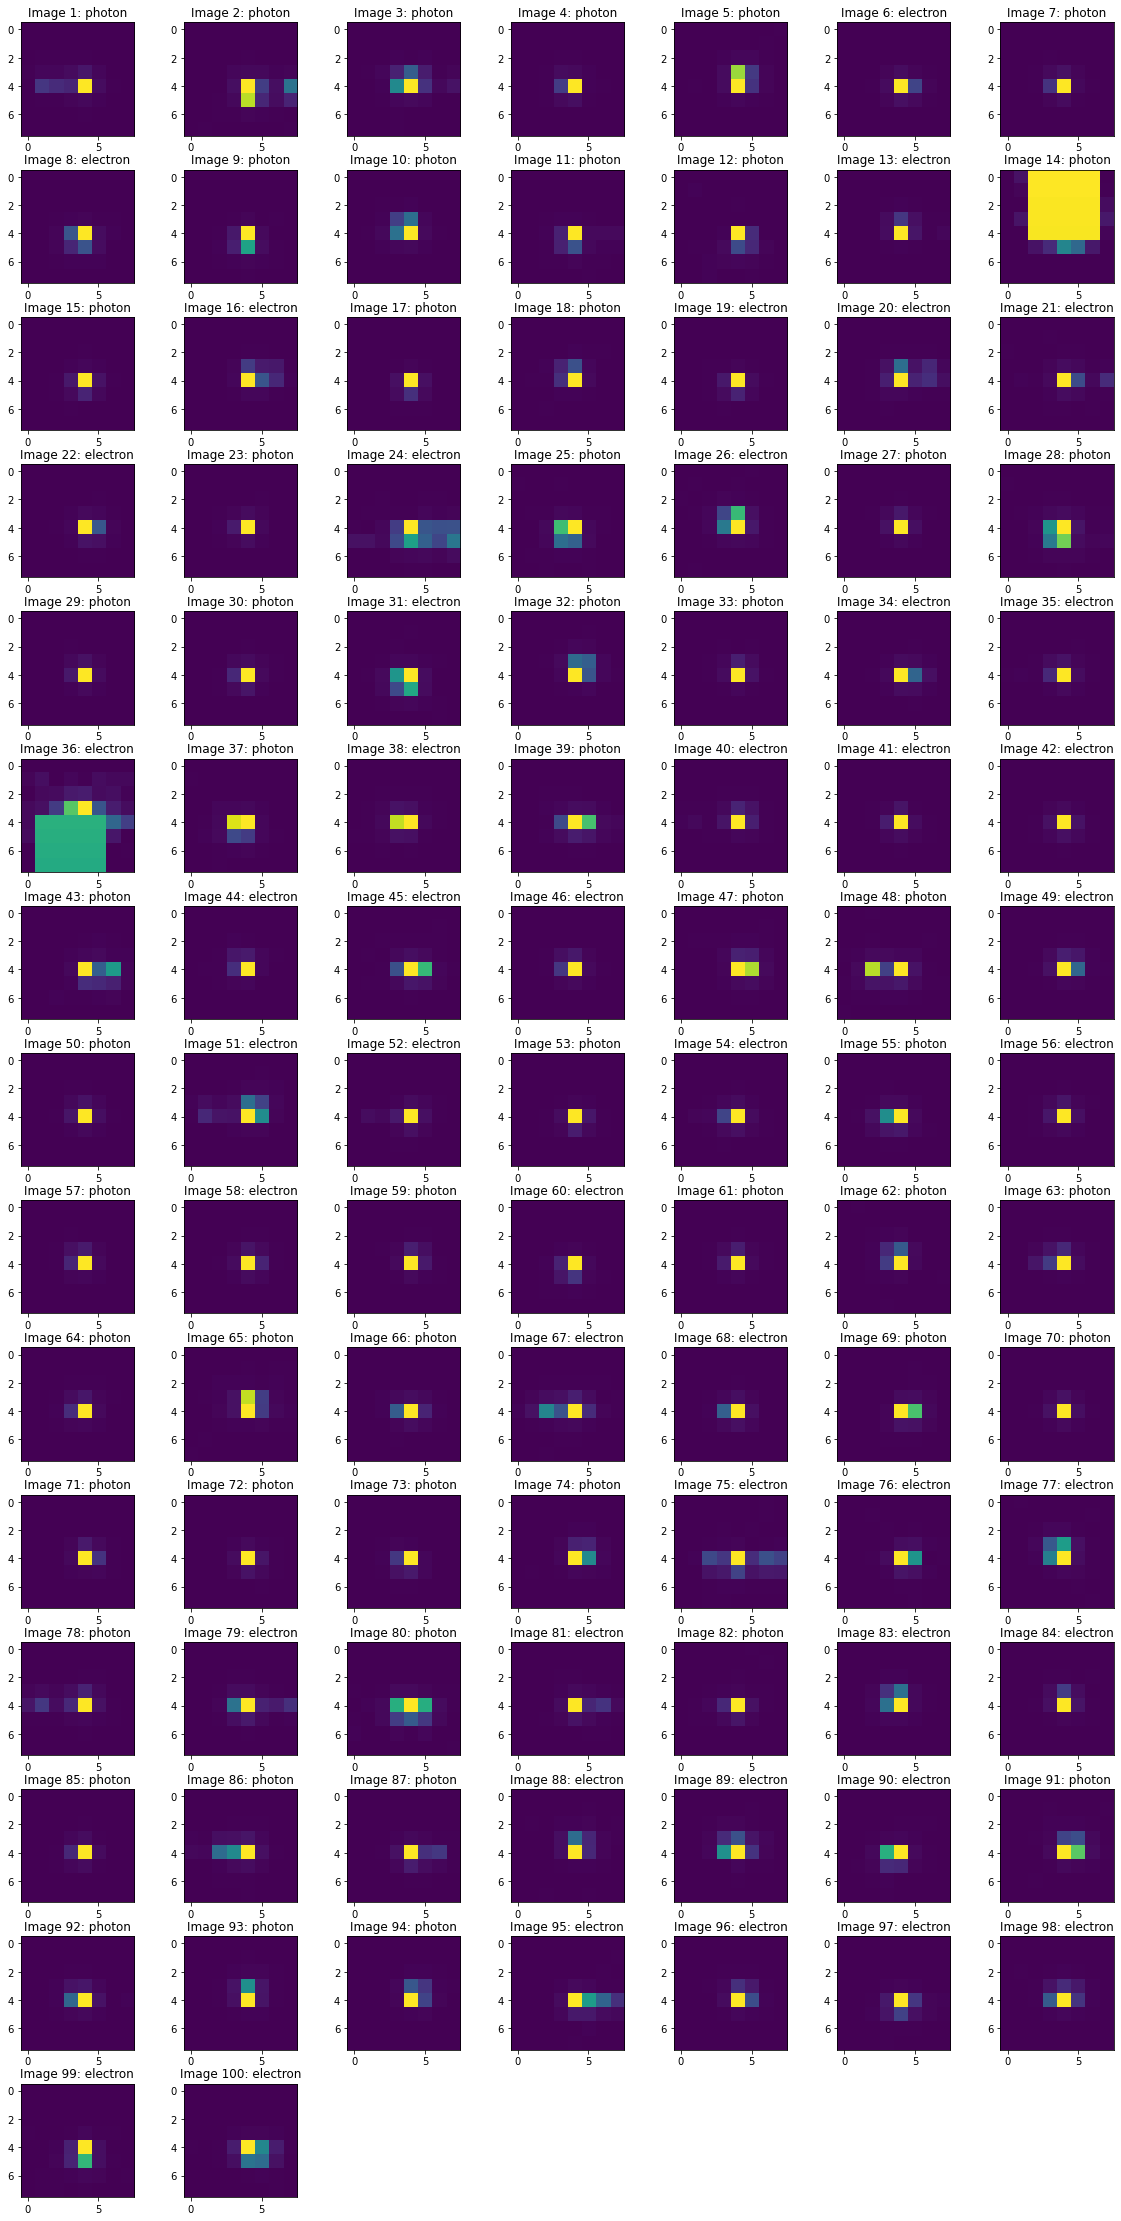

In [9]:
vitualize_image(x_test_cropped, y_test)

## 2.2 Image Compression

Still the image size (8x8) = 64 is too large to be fed to the quantum circuit. 

A more reasonable size will be (4x4) = 16 which requires 16 qubits to encode the image

In [10]:
# add the color channel
x_train_ = np.reshape(x_train_cropped, list(x_train_cropped.shape)+[1])
x_test_ = np.reshape(x_test_cropped, list(x_test_cropped.shape)+[1])
# here we will use the image resize function from tensorflow for compressing the image
x_train_small = np.array([tf.image.resize(img, (4,4)).numpy() for img in x_train_])
x_test_small = np.array([tf.image.resize(img, (4,4)).numpy() for img in x_test_])
x_train_small = np.reshape(x_train_small, x_train_small.shape[:3])
x_test_small = np.reshape(x_test_small, x_test_small.shape[:3])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

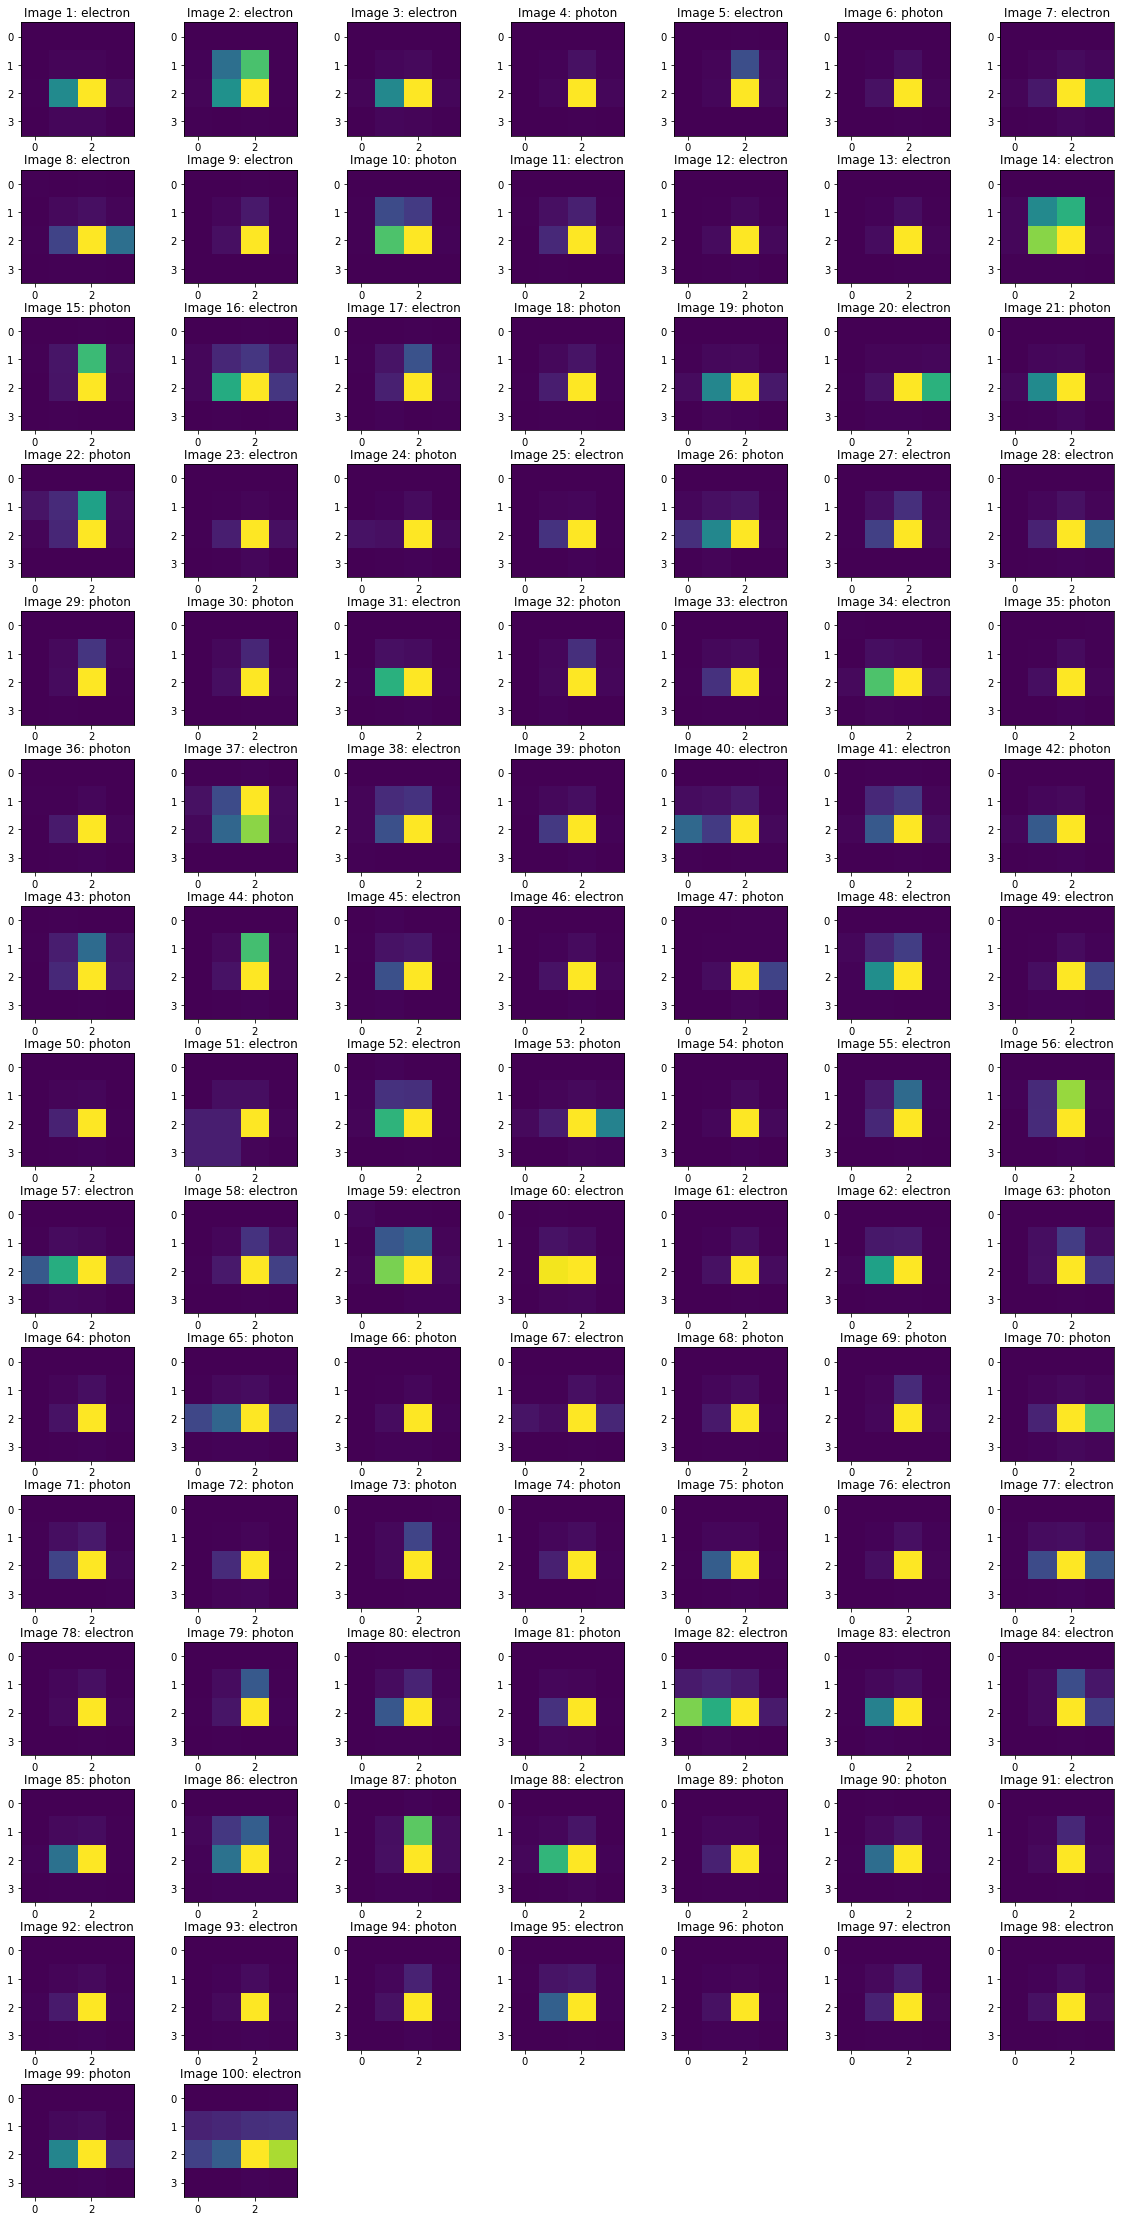

In [11]:
# let's see how the compressed images look
vitualize_image(x_train_small, y_train)

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

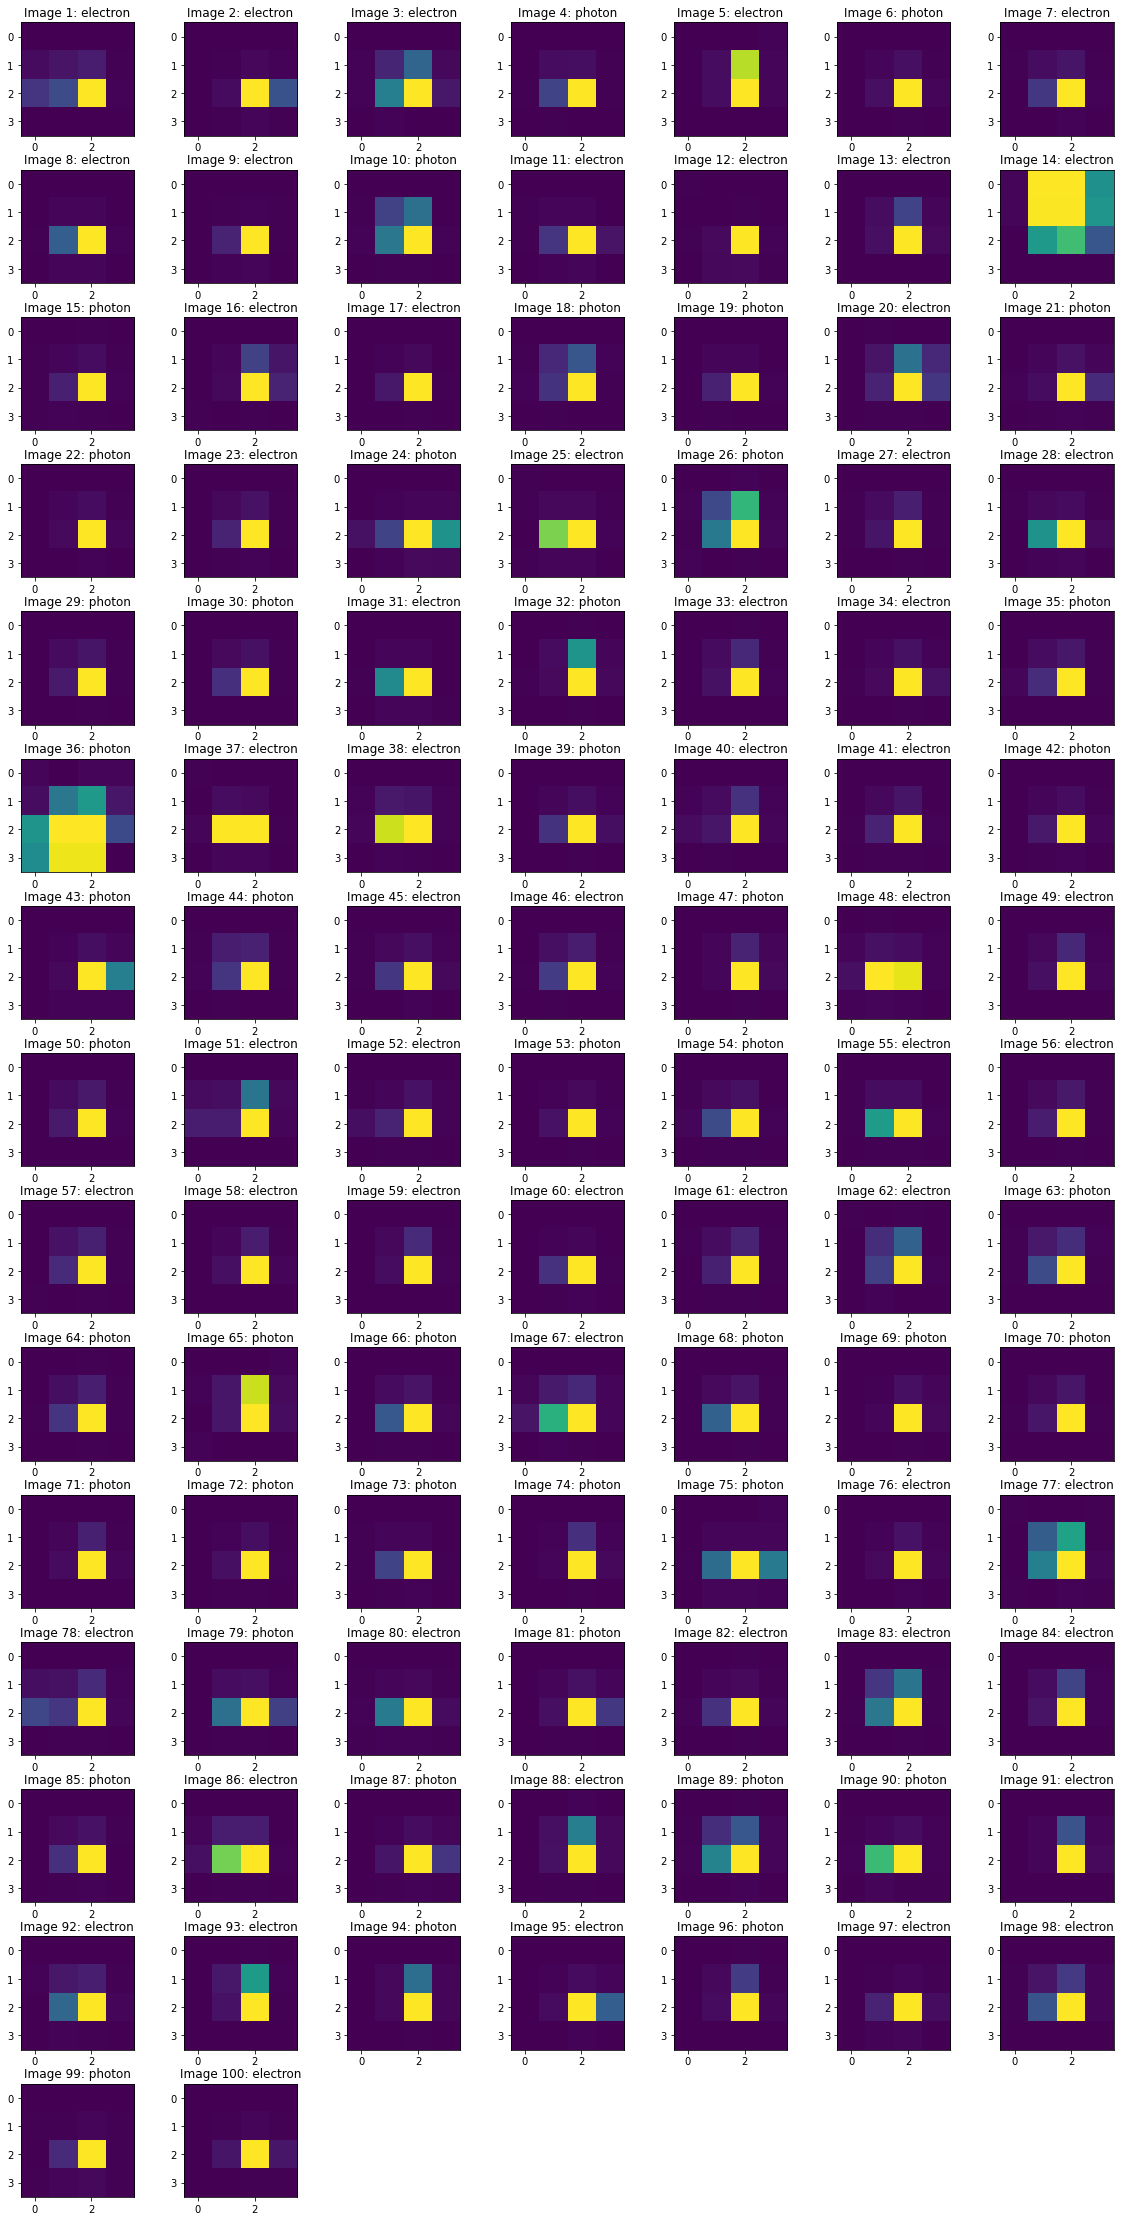

In [12]:
vitualize_image(x_test_small, y_train)

### Rescale data to the range appropriate for quantum data encoding

- Usually classical data is encoded as the rotation angle of a gate operation in a quantum circuit which has a valid range of $[-\pi,+\pi]$. However, from past experience a smaller range will suffice and even show better performance than the valid range itself. So for this task, we will be **rescaling our data to a unit range (i.e. $[0, +1]$)** following the range used by  the`tensorflow_quantum` tutorial for MNIST classification (https://www.tensorflow.org/quantum/tutorials/mnist). Alternative, one may also use another common range $[-1, +1]$ for example from https://arxiv.org/abs/1906.10467.

In [13]:
def rescale_data(*data, val_range = (0, 1.)):
    min_value = np.min(data)
    max_value = np.max(data)
    range_min = val_range[0]
    range_max = val_range[1]
    rescaled_data = tuple([(((d-min_value)/(max_value-min_value))*(range_max-range_min))+range_min for d in data])
    return rescaled_data
x_train_rescaled, x_test_rescaled = rescale_data(x_train_small, x_test_small)
x_train_final = np.array([i.flatten() for i in x_train_rescaled])
x_test_final = np.array([i.flatten() for i in x_test_rescaled])

# 3. Create our QCNN model

- The main references are Cong (https://arxiv.org/pdf/1810.03787.pdf) and Oh (https://arxiv.org/pdf/2009.09423.pdf) which uses  variational (parameterised) quantum circuits for the convolution, pooling and fully connected layers which is also what is supported by `tensorflow_quantum`. 

## 3.1 Implement model structure, optimizer, loss function and metrics
- The **Mean Squared Error (MSE)** is used as the default loss function. 

- The **Adam optimizer** is used for optimizing the parameters in the variational quantum circuit layers to minimize the loss function.

- The **Area Under the ROC curve (AUC)** is used as the default metric.

- A `random_state` option is added to allow for reproducible result

In [14]:
from typing import Optional, Union

from sklearn.metrics import roc_curve, auc, roc_auc_score
import quple
from quple.utils.utils import plot_roc_curve

class QCNN(tf.keras.Sequential):
    """Quantum Convolutional Neural Network (QCNN)
    """    
    def __init__(self, encoding_circuit:'cirq.Circuit', variational_circuit:'cirq.Circuit', 
                 lr=1e-4,
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,
                 loss='mse', 
                 metrics=['auc'],                 
                 readout=None,
                 random_state:int=2,                 
                 name:str='QCNN', *arg, **args):
        """ Creates a variational quantum classifier
        
        Args:
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit used for data encoding.
            variational_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit which the parameters
                are to be tuned by a classical optimizer.
            optimizer: string (name of optimizer)or tf.keras.optimizers.Optimizer instance; default='adam'
                The optimizer to use for tuning the parameters in the
                variational circuit. 
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement
            loss: string (name of objective function), objective function or tf.keras.losses.Loss instance
                An objective function of the form f_n(y_true,y_pred) which maps truth labels and the predicted
                labels to some loss values. 
            activation: string (name of activation function) or activation function instance
                The activation function for the output layer.
            metrics: List of string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
                List of metrics to be evaluated by the model during training and testing. 
            readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects
                Measurement operators (observables) for the variational circuit layer.
            trainable_dense_layer: boolean; default=False
                Whether to train the weights in the the classical output layer.
            random_state: Optional int
                The random state for reproducible result.
            name: Optional str, default='QCNN'
                Name given to the classifier.
        """
        super(QCNN, self).__init__()
        self.readout = readout
        self.encoding_circuit = encoding_circuit
        self.variational_circuit = variational_circuit
        self.differentiator = differentiator        
        self.regularizer = regularizer
        self.repetitions = repetitions    
        self.random_state = random_state
        self.set_random_state(self.random_state)
        layers = self._get_vqc_layers()
        super(QCNN, self).__init__(layers, name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        # do some treaks to allow for using auc as a metric
        self.auc_metric = tf.keras.metrics.AUC()
        metrics_ = []
        for metric in metrics:
            if metric.lower() == 'auc':
                metrics_.append(self.custom_auc)
            else:
                metrics_.append(metric)
        self.compile(loss=loss, optimizer=optimizer, metrics=metrics_)
        
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)       
        
    def _get_vqc_layers(self):
        # input layer for feeding quantum circuit encoded with classical data as tensorflow string
        input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string)
        
        if not self.readout:
            # by default measure PauliZ on first qubit
            qubits = quple.get_circuit_qubits(self.variational_circuit)
            readout = [cirq.Z(qubits[0])]
        else:
            readout = self.readout    
        # variational layer for implementing convolution and pooling
        pqc_layer = tfq.layers.PQC(self.variational_circuit,
                                   readout,
                                   repetitions=self.repetitions,
                                   differentiator=self.differentiator,
                                   regularizer=self.regularizer)
        return [input_layer, pqc_layer]  
                
    def convert_to_tensor(self, x:np.ndarray):
        """Encode classical data into quantum circuits and convert circuit to tensorflow string"""
        return tfq.convert_to_tensor(self.encoding_circuit.resolve_parameters(x))                    

    def compile(self, optimizer='adam', loss='binary_crossentropy', 
                metrics=['binary_accuracy'], *args, **kwargs):
        super(QCNN, self).compile(optimizer, loss, metrics, *args, **kwargs)

    @tf.function
    def custom_auc(self, y_true, y_pred):
        y_pred_ = (y_pred+1)/2
        return self.auc_metric(y_true, y_pred_)
    
    def train(self, x_train, y_train, x_val=None, y_val=None, 
              batch_size:Optional[int]=None,
              epochs:int=100, 
              weights=None,
              *args, **kwargs):

        if weights is None:
            weights = (None, None, None)
            
        if (x_val is None) and (y_val is None):
            validation_data = None
        else:
            validation_data = (x_val, y_val) if weights is None else (x_val, y_val, weights[1])
 
        self.fit(x_train, y_train, batch_size, epochs,
                 validation_data=validation_data,
                 sample_weight=weights[0])

    def fit(self, x, y,
            batch_size:Optional[int]=None,
            epochs:int=1, 
            validation_data=None,
            *args, **kwargs):
        
        if isinstance(x, np.ndarray):
            x = self.convert_to_tensor(x)
            
        if validation_data and isinstance(validation_data, tuple):
            self._attributes['val_size'] = len(validation_data[0])
            if isinstance(validation_data[0], np.ndarray):
                x_val = self.convert_to_tensor(validation_data[0])
                validation_data = (x_val, *validation_data[1:])
                
        return super(QCNN, self).fit(x, y,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_data=validation_data,
                                    *args, **kwargs)
    
    def evaluate(self, x, y, *args, **kwargs):
        if isinstance(x, np.ndarray):
            x = self.convert_to_tensor(x)
        return super(QCNN, self).evaluate(x, y, *args, **kwargs)
    
    def predict(self, x, *args, **kwargs):
        if isinstance(x, np.ndarray):
            x = self.convert_to_tensor(x)
        return super(QCNN, self).predict(x, *args, **kwargs)    
    
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QDCGAN')
        else:
            return roc_auc    

## Remark: Quantum Circuit Construction

For easy contruction of quantum circuits for data encoding, convolution and pooling, we will use the `ParameterisedCircuit` class from the `quple` module (a package made by the author of this notebook)

What does the `ParameterisedCircuit` class do?
- It uses a layered approach for applying quantum gates. A rotation layer consist of a single qubit gate applied to every qubit. An entanglement layer consist of multi-qubit gate applied to specific pairs/sets of qubits according to the `entangle_strategy`. 
- Parameters are automatically added to operations that requires it. Users can control whether to repeat the parameters at a certain stage. For the case of data encoding, a derived class `EncodingCircuit` is used where the parameters should repeat every layer. 
- The argument `copies` is the **circuit depth**.
- The argument `rotation_blocks` specify a series of single qubit operations to be applied to each of the qubits.
- The argument `entanglement_blocks` specify a series of multiple qubit operations to be applied to a designated set of qubits
- The argument `entangle_strategy` specify the connectivity graph of the qubits. Here `alternate_linear` means every neighboring pair is connected but in an alternating manner.

## 3.1 Quantum Data Encoding

For easy contruction of quantum circuits for data encoding, we will use the `EncodingCircuit` class from the `quple` module (a package made by the author of this notebook).

Here we implement the encoding circuits used by the seminal IBM paper: https://arxiv.org/abs/1804.11326(which proposes the Quantum Support Vector Machine algorithm and the Variational Quantum Classifier algorithm). 

Essentially, the encoding circuit consist of a layer of single-qubit `RZ` rotation which encodes each pixel value of the input image as the rotation angle on the corresponding qubit along the $Z$-axis. It is then followed by a layer of two-qubit `RZZ` rotation which which encode the $i$-th pixel and $j$-th pixel values as the rotation along the $Z_{i}\otimes Z_{j}$-axis of the $i$-th and $j$-th qubit via some encoding function $\theta_{i,j}(x_i, x_k)$. Here the encoding function used is $\theta_{i,j} = [((x_i + x_k)/2]^3$.

In [15]:
import cirq
# let's define the grid qubit layout that matches the image dimension, i.e. (4 x 4)
qubits = cirq.GridQubit.rect(4, 4)
qubits

[cirq.GridQubit(0, 0),
 cirq.GridQubit(0, 1),
 cirq.GridQubit(0, 2),
 cirq.GridQubit(0, 3),
 cirq.GridQubit(1, 0),
 cirq.GridQubit(1, 1),
 cirq.GridQubit(1, 2),
 cirq.GridQubit(1, 3),
 cirq.GridQubit(2, 0),
 cirq.GridQubit(2, 1),
 cirq.GridQubit(2, 2),
 cirq.GridQubit(2, 3),
 cirq.GridQubit(3, 0),
 cirq.GridQubit(3, 1),
 cirq.GridQubit(3, 2),
 cirq.GridQubit(3, 3)]

In [16]:
from quple.data_encoding import EncodingCircuit
from quple import PauliBlock
from quple.data_encoding.encoding_maps import polynomial
encoding_circuit = EncodingCircuit(qubits, copies=2,
                                    rotation_blocks=['H', 'RZ'],
                                    entanglement_blocks=[PauliBlock('ZZ', polynomial(degree=3))],
                                    entangle_strategy='linear')

encoding_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)────@────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<x_0/pi>)────@───────────────────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                  │                                    │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               │                                                   │
(0, 1): ───H───Rz(pi*<x_1/pi>)────X───Rz(pi*<(x_0/2 + x_1/2)**3/pi>)───X───@────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<x_1/pi>)────X──────────────────Rz(pi*<(x_0/2 + x_1/2)**3/pi>)───X───@────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                           │                                    │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## 3.2 Constructing the Convolution and Pooling layers

- Major reference: Cong (https://arxiv.org/pdf/1810.03787.pdf) and Oh (https://arxiv.org/pdf/2009.09423.pdf) 

In [17]:
from quple import ParameterisedCircuit, ParameterisedBlock
def ConvLayer(qubits):
    conv_block = ParameterisedBlock(copies=1, rotation_blocks=['RZ','RY','RX'], entanglement_blocks=['ZZ','YY','XX'])
    conv_layer = ParameterisedCircuit(qubits, copies=1,
                                      rotation_blocks=[],
                                      entanglement_blocks=[conv_block],
                                      entangle_strategy='filter_mesh')
    return conv_layer

def PoolLayer(qubits):
    pool_block = ParameterisedBlock(copies=1, rotation_blocks=['RZ','RY','RX'], entanglement_blocks=['CX'])
    conv_layer = ParameterisedCircuit(qubits, copies=1,
                                      rotation_blocks=[],
                                      entanglement_blocks=[pool_block],
                                      entangle_strategy='pool_mesh')
    return conv_layer

In [18]:
# let's demonstrate how the two layers work
example_grid_qubits = cirq.GridQubit.rect(2, 2)
example_conv_layer = ConvLayer(example_grid_qubits)
example_pool_layer = PoolLayer(example_grid_qubits)

In [19]:
example_conv_layer

(0, 0): ───Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX────────────────────────────────────────────────────────────────────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX────────────────────────────────────────────────────────────────────────
                                         │          │          │                                                                                                       │          │          │
(0, 1): ───Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───ZZ^(θ_6)───YY^(θ_7)───XX^(θ_8)────────────────────────────────────────────────────────────────────────────────────────────────┼──────────┼──────────┼──────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX─────────
                                                                                                                                                                       │          │          │                                        │          │          │
(1, 0): ──────────────────────────────────────────────────────────────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX─────────Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───ZZ^(θ_6)───YY^(θ_7)───XX^(θ_8)─────────────────────────────────┼──────────┼──────────┼──────────
                                                                                                        │          │          │                                                                                                       │          │          │
(1, 1): ──────────────────────────────────────────────────────────────────Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───ZZ^(θ_6)───YY^(θ_7)───XX^(θ_8)──────────────────────────────────────────────────────────────────Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───ZZ^(θ_6)───YY^(θ_7)───XX^(θ_8)───

The **convolutional layer** is made up of circuit blocks that serve as **filters** to the input data. Each filter works on two qubits (so a (1x2) filter). The filter first rotate each qubit with `RZ`, `RY` and `RX` gates by a parameterised angle which served as weights to the filter. Then a sequence of three parameterised two-qubit gates `ZZ`, `YY` and `XX` gates are applied which entangles the two corresponding qubits and extract feature information from them. 

In principle, any sets of parameterised single qubit and two qubit gates should work. Here we use as many as we can to make the filter learn more parameters. 

From the example circuit above, we see that the filter is applied to the qubit pairs $[(0, 0),(0,1)], [(1,0),(1,1)], [(0,0),(1,0)], [(0,1),(1,1)]$ which essentially scans through all neighboring 1 x 2 pixel pairs. 

In [20]:
example_pool_layer

(0, 0): ───Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───@─────────────────────────────────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───@─────────────────────────────────────
                                         │                                                                   │
(0, 1): ───Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───X───────────────────────────────────────────────────────────────────┼───Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───@───
                                                                                                             │                                 │
(1, 0): ─────────────────────────────────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───@───Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───X─────────────────────────────────┼───
                                                                           │                                                                   │
(1, 1): ─────────────────────────────────────Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───X─────────────────────────────────────Rz(θ_1)───Ry(θ_3)───Rx(θ_5)───X───

The **pooling layer** is made up of circuit blocks that for **down sampling of the convolution feature map**. Each circuit block acts on two qubits which their information are to be combined. Each blocks start with single qubit rotations of `RZ`, `RY` and `RX` gates with a parameterised angle which served as weights to control the down sampling. Then a `CNOT` gate is applied to the two qubits of interest. One of the qubit will serve as the source and the other as the target. Depending on the state of the source qubit, there will be a bit flip on the target qubit. This essentially creates a down sampling effect to carry the information from the source qubit to the target qubit.

In principle, any sets of parameterised single qubit and two qubit gates should work. Here we use as many as we can to make the filter learn more parameters. 

From the example circuit above, we see that the pooling is applied to the qubit pairs $[(0, 0),(0,1)], [(1,0),(1,1)], [(0,0),(1,0)], [(0,1),(1,1)]$ which essentially merge the 2 x 2 pixels into one. 

### Parameterized Qubit Entanglement as (1x2) Filters 

We see that the convolution layer uses parameterised qubit entanglement as (1 x 2) filters. Let's visualize how the filters are applied on the pair of qubits.

In [21]:
def vitualize_qubits(img, connectivity):
    fig = plt.figure(figsize=(20,15))
    columns = 6
    rows = 4
    for i, c in enumerate(connectivity):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Connectivity: {}'.format(c))
        plt.imshow(img[i])
    return plt

We begin with our 4 x 4 grid of qubits. The same filter (circuit block parameterised with the same weight) scans across all neighboring qubit pairs as shown below:

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

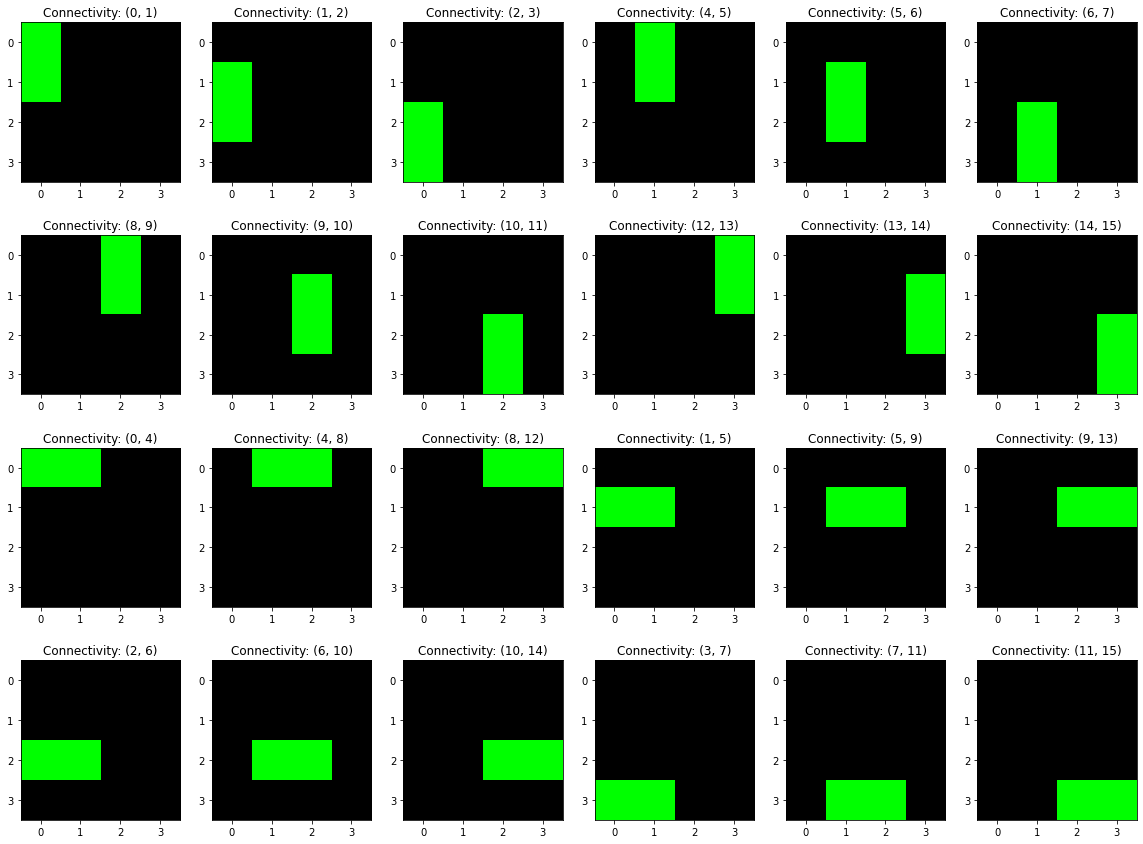

In [22]:
from quple.components.interaction_graphs import filter_mesh
qubit_connectivity = filter_mesh(n=4*4)
qubit_layouts = np.zeros((24, 4, 4, 3))
for i, c in enumerate(qubit_connectivity):
    qubit_layouts[i, c[0]%4, c[0]//4, 1] = 1
    qubit_layouts[i, c[1]%4, c[1]//4, 1] = 1
vitualize_qubits(qubit_layouts, qubit_connectivity)

After the pooling we will have an effect 2 x 2 grid. Another different filter (circuit block parameterised with another set of weights) is applied across the new pair of qubits:

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

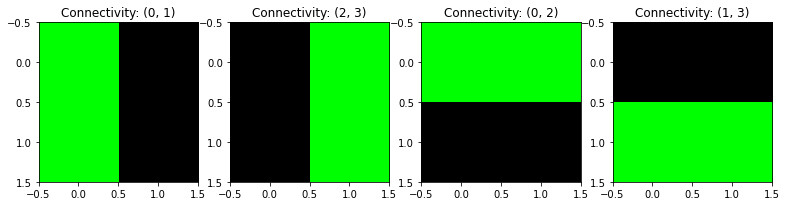

In [23]:
from quple.components.interaction_graphs import filter_mesh
qubit_connectivity = filter_mesh(n=2*2)
qubit_layouts = np.zeros((24, 2, 2, 3))
for i, c in enumerate(qubit_connectivity):
    qubit_layouts[i, c[0]%2, c[0]//2, 1] = 1
    qubit_layouts[i, c[1]%2, c[1]//2, 1] = 1
vitualize_qubits(qubit_layouts, qubit_connectivity)

In [24]:
print('The (1x2) quantum filter runs through these pairs of qubits:')
print(qubit_connectivity)

The (1x2) quantum filter runs through these pairs of qubits:
[(0, 1), (2, 3), (0, 2), (1, 3)]


### Non-parameterized Entanglement Gate as Pool operators

Next let's look at which qubits pairs are merged by the pooling circuit block. Starting with the 4 x 4 grid:

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

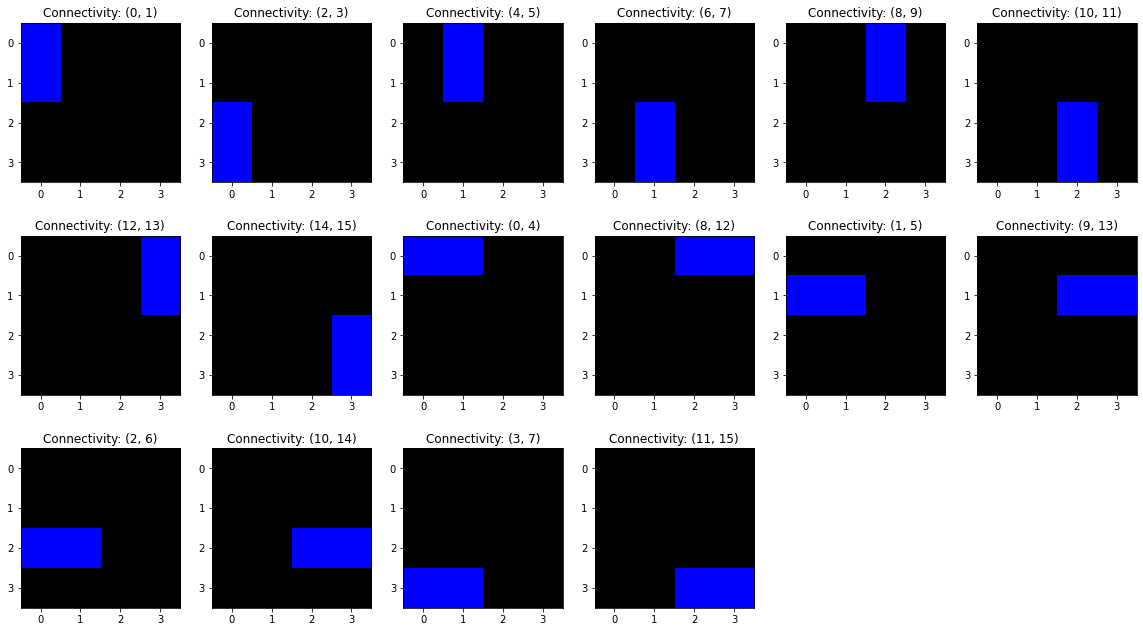

In [25]:
from quple.components.interaction_graphs import pool_mesh
qubit_connectivity = pool_mesh(n=4*4)
qubit_layouts = np.zeros((24, 4, 4, 3))
for i, c in enumerate(qubit_connectivity):
    qubit_layouts[i, c[0]%4, c[0]//4, 2] = 1
    qubit_layouts[i, c[1]%4, c[1]//4, 2] = 1
vitualize_qubits(qubit_layouts, qubit_connectivity)

Then with the 2 x 2 grid. After this stage, we end up with an effective 1x1 grid. This essentially means a **fully-connected layer is no longer necessary which we will indeed skip for this task**.

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

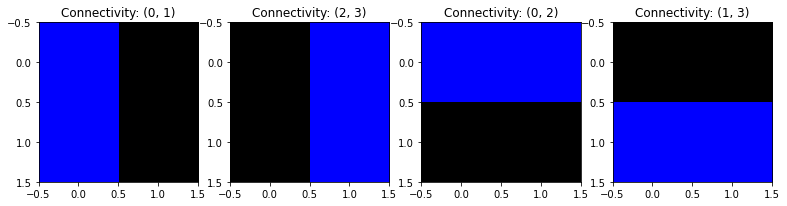

In [26]:
from quple.components.interaction_graphs import pool_mesh
qubit_connectivity = pool_mesh(n=2*2)
qubit_layouts = np.zeros((24, 2, 2, 3))
for i, c in enumerate(qubit_connectivity):
    qubit_layouts[i, c[0]%2, c[0]//2, 2] = 1
    qubit_layouts[i, c[1]%2, c[1]//2, 2] = 1
vitualize_qubits(qubit_layouts, qubit_connectivity)

Now actually create the entire variational circuit block with all the convolution and pooling layers

In [27]:
import cirq
qubits_layer1 = cirq.GridQubit.rect(4, 4)
variational_circuit = ParameterisedCircuit(qubits_layer1)
variational_circuit.merge(ConvLayer(qubits_layer1))
variational_circuit.merge(PoolLayer(qubits_layer1))
# Now we have an effective 2x2 image
# Apply the convolution and pooling again to reduce it to 1x1
qubits_layer2 = [qubit for i,qubit in enumerate(qubits_layer1) if i%4 ==0]
variational_circuit.merge(ConvLayer(qubits_layer2))
variational_circuit.merge(PoolLayer(qubits_layer2))
variational_circuit

(0, 0): ───Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_9)────Ry(θ_11)───Rx(θ_13)───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_9)────Ry(θ_11)───Rx(θ_13)───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_15)───Ry(θ_17)───Rx(θ_19)───ZZ──────────YY──────────XX───────────────────────────────────────────────────────────────────────────────Rz(θ_15)───Ry(θ_17)───Rx(θ_19)───ZZ──────────YY──────────XX───────────────────────────────────────────────────────────────────────────────Rz(θ_24)───Ry(θ_26)───Rx(θ_28)───@────────────────────────────────────────Rz(θ_24)───Ry(θ_26)───Rx(θ_28)───@────────────────────────────────────────
                                         │          │          │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │          │          │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Then build our QCNN model with the encoding circuit and variational circuit we just constructed

In [28]:
qcnn = QCNN(encoding_circuit=encoding_circuit, variational_circuit=variational_circuit, lr=5e-3,
            loss='mse', random_state=1)

In [29]:
qcnn.summary()

Model: "QCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [30]:
# start the training
qcnn.train(x_train_final, y_train, batch_size=10, epochs=30)

Epoch 1/30
10/10 [==============================] - 4s 353ms/step - loss: 0.5206 - custom_auc: 0.4546 - auc: 0.3975
Epoch 2/30
10/10 [==============================] - 3s 344ms/step - loss: 0.3914 - custom_auc: 0.4729 - auc: 0.5051
Epoch 3/30
10/10 [==============================] - 4s 350ms/step - loss: 0.3418 - custom_auc: 0.5620 - auc: 0.5986
Epoch 4/30
10/10 [==============================] - 4s 355ms/step - loss: 0.3062 - custom_auc: 0.6653 - auc: 0.6108
Epoch 5/30
10/10 [==============================] - 3s 341ms/step - loss: 0.2781 - custom_auc: 0.6065 - auc: 0.5037
Epoch 6/30
10/10 [==============================] - 3s 344ms/step - loss: 0.2600 - custom_auc: 0.5757 - auc: 0.5081
Epoch 7/30
10/10 [==============================] - 3s 346ms/step - loss: 0.2492 - custom_auc: 0.6034 - auc: 0.6254
Epoch 8/30
10/10 [==============================] - 3s 348ms/step - loss: 0.2465 - custom_auc: 0.5849 - auc: 0.5873
Epoch 9/30
10/10 [==============================] - 3s 348ms/step - loss

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

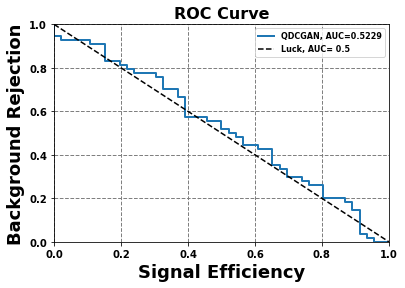

In [31]:
qcnn.test(x_test_final, y_test)

So we see that the final test **auc** is only **0.5229** which is **very bad**. There is obvious **overfitting** during the training. 

One way to circumvent this will be to add another **validation data** for the training.

Also since we have **low statistics** (only 100 samples for training), we don't expect the model to learn well.

Another possible reason for the poor result will be from the data preprocessing techniques.

So let's study further with other data preprocessing:

# 4. Further Studies

## 4.1 Image Compression using AutoEncoders


One technique for compressing the image will be the use of **auto encoder**.

For the task to run in a reasonably short amount of time. A **final data size of 8** should be good. So let's do that.

**Some comments**:

Ideally, we should feed our QCNN model with actual images instead of a compressed one. However, due to heavy computational cost of simulation of quantum circuits with larg number of qubits we need to make compromises. 

So for now we will **assume that the compressed data represents an image**, probably of dimension (2 x 4). 

In [32]:
import tensorflow as tf

class Residual(tf.keras.models.Model):
    """
    Residual network for auto encoder
    """
    
    def __init__(self, n_filters, activation=tf.nn.relu):
        super().__init__()
        self.convolution1 = tf.keras.layers.Convolution2D(
            kernel_size = [3, 3], 
            filters     = n_filters,
            padding     = "same",
            activation  = None,
        )
        self.convolution2 = tf.keras.layers.Convolution2D(
            kernel_size = [3, 3], 
            filters     = n_filters,
            padding     = "same",
            activation  = None,
        )
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.activation = activation
        
    def call(self, inputs):
        # first convolution
        x = self.convolution1(inputs)
        x = self.batch_norm1(x)
        x = self.activation(x)
        # second convolution
        x = self.convolution2(x)
        x = self.batch_norm2(x)
        x = x + inputs 
        x = self.activation(x)
        return x

class Encoder(tf.keras.models.Model):
    def __init__(self, latent_size, n_filters, activation=tf.nn.relu):
        super().__init__()
        self._latent_size = latent_size
        
        # Apply a 3x3 kernel to the image:
        self.encoder_layer_1 = Residual(activation=activation, n_filters=n_filters)
        
        # Use a 2x2 kernel of stride 2x2 to downsample:
        self.pool_1 = tf.keras.layers.MaxPool2D()
        
        self.encoder_layer_2 = Residual(activation=activation, n_filters=n_filters)
        self.pool_2 = tf.keras.layers.MaxPool2D()
        
        self.encoder_layer_3 = Residual(activation=activation, n_filters=n_filters)
        self.pool_3 = tf.keras.layers.MaxPool2D()

        self.encoder_layer_final = tf.keras.layers.Dense(
            units = latent_size,
            activation = None,
            )

    def call(self, inputs):
        
        # input_shape = [batch_size, width, height, color]
        batch_size = inputs.shape[0]
        x = inputs
        x = self.encoder_layer_1(x)
        x = self.pool_1(x)
        x = self.encoder_layer_2(x)
        x = self.pool_2(x)
        x = self.encoder_layer_3(x)
        x = self.pool_3(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.encoder_layer_final(x)
        return tf.reshape(x, [batch_size, self._latent_size])
    
class Decoder(tf.keras.models.Model):
    
    def __init__(self, dimension, n_filters, activation=tf.nn.tanh):
        super().__init__()
        
        self._dimension = dimension
        self._n_filters = n_filters
        
        self.dense = tf.keras.layers.Dense(
            units = 3 * 3 * n_filters
        )
        self.decoder_layer_1 = Residual(n_filters=n_filters, activation=activation)      
        self.unpool_1 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )
        self.decoder_layer_2 = Residual(n_filters=n_filters, activation=activation)
        self.unpool_2 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )
        self.decoder_layer_3 = Residual(n_filters=n_filters, activation=activation)
        self.decoder_layer_final = tf.keras.layers.Convolution2D(
            kernel_size = [1, 1],
            filters     = 1,
            padding     = "same",
            use_bias    = True,
            activation  = None,
        )

        
    def call(self, inputs):
        
        batch_size = inputs.shape[0]
        
        x = self.dense(inputs)
        # First Step is to to un-pool the encoded state into the right shape:
        x = tf.reshape(x, [batch_size, 3, 3, self._n_filters])
        x = tf.image.resize(
            x,
            size=[int(self._dimension/4), int(self._dimension/4)]
        )
        x = self.decoder_layer_1(x)
        x = self.unpool_1(x)
        x = self.decoder_layer_2(x)
        x = self.unpool_2(x)
        x = self.decoder_layer_3(x)
        x = self.decoder_layer_final(x)
        x = tf.nn.sigmoid(x)
        x = tf.reshape(x, [batch_size, self._dimension, self._dimension, 1])
        return x        

In [33]:
class AutoEncoder(object):
    def __init__(self, dimension, latent_size=8, n_filters=64, batch_size=10, epochs=100,
                 lr=1e-4):
        self.latent_size = latent_size
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.dimension = dimension
        self.epochs = epochs
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        self.encoder = Encoder(latent_size=latent_size, n_filters=n_filters)
        self.decoder = Decoder(dimension=dimension, n_filters=n_filters)
        
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        return batches
    
    def setup_display(self):
        # define a figure for updating the loss progress and checking quality of encoded images
        self.fig = plt.figure(figsize=(16,9))        
        gs = gridspec.GridSpec(2, 2)
        self.ax_loss   = plt.subplot(gs[:,0])
        self.ax_input  = plt.subplot(gs[0,1])
        self.ax_output = plt.subplot(gs[1,1])
        
    def train(self, x_train, x_val, interactive_display=True, save_weights=True):
        
        if interactive_display:
            self.setup_display()
        
        train_size = x_train.shape[0]
        # for bookkeeping
        steps = []
        val_steps = []
        loss_arr = []
        val_loss_arr = []
        
        # since the input is of the shape [batch_size, width, height], i.e. without color channel
        # need to reshape it to [batch_size, width, height, color]
        image_shape = [x_train.shape[0], x_train.shape[1], x_train.shape[2], 1]
        reshaped_x_train = x_train.reshape(image_shape)
        reshaped_x_val = x_val.reshape(image_shape)
        for epoch in range(self.epochs):
            # prepare batched data for training
            batches = self.create_batches(reshaped_x_train, self.batch_size)
            for i, batch_images in enumerate(batches):
                with tf.GradientTape() as tape:
                    intermediate_state = self.encoder(batch_images)
                    decoded_images = self.decoder(intermediate_state)
                    loss_value = tf.reduce_mean(tf.losses.binary_crossentropy(batch_images, decoded_images))
                    
                # collect the trainable variables as the union of the encoder and decoder variables:
                trainable_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
                
                # apply the update to the model:
                grads = tape.gradient(loss_value, trainable_vars)
                self.optimizer.apply_gradients(zip(grads, trainable_vars))
                
                # record the results
                step = epoch + (i*self.batch_size)/train_size
                steps.append(step)
                loss_arr.append(loss_value.numpy())

                # test performance every 5 batches
                if i % 5 == 0:
                    test_images = [i for i in self.create_batches(reshaped_x_val, self.batch_size)][0]
                    val_intermediate_state = self.encoder(test_images)
                    decoded_images = self.decoder(val_intermediate_state)
                    val_loss_value = tf.reduce_mean(tf.losses.binary_crossentropy(test_images, decoded_images))
        
                    val_steps.append(step)
                    val_loss_arr.append(val_loss_value.numpy())
                         
                    if interactive_display:
                        self.display_progress(steps, loss_arr, val_steps, val_loss_arr, test_images, decoded_images)
                        
        # finally save the model weights
        if save_weights:
            self.encoder.save_weights("encoder_weights.h5")
            self.decoder.save_weights("decoder_weights.h5")    
        
    def display_progress(self, steps, loss_arr, val_steps, val_loss_arr, test_images, decoded_images):
        dimension = test_images.shape[1]
        # Here we update the plots.  Replot the loss, and show the latest input and output images
        self.ax_loss.set_xlim(0, 1.1*np.max(steps))
        self.ax_loss.cla()
        self.ax_loss.plot(steps, loss_arr, label="Train Loss")
        self.ax_loss.plot(val_steps, val_loss_arr, label="Test Loss")
        self.ax_loss.grid(True)
        self.ax_loss.legend(fontsize=25)
        self.ax_loss.set_xlabel('Epoch', fontsize=20)
        self.ax_loss.set_ylabel('Binary Cross Entropy Loss', fontsize=20)        
        # Display an input image (the first one):
        self.ax_input.imshow(test_images[0].numpy().reshape(dimension, dimension))
        self.ax_input.set_xlabel('True Image', fontsize=15)
        # Display an output image (the first one):
        self.ax_output.imshow(decoded_images[0].numpy().reshape(dimension, dimension))
        self.ax_output.set_xlabel('Decoded Image', fontsize=15)
        display(self.fig)
        clear_output(wait = True)
        
    def encode_samples(self, x):
        """Compress image using encoder."""
        reshaped_x = tf.reshape(x, list(x.shape[:3])+[1])
        result = self.encoder(reshaped_x)
        return tf.reshape(result, result.shape[:3])
    
    def decode_samples(self, x):
        """Uncompress image using decoder."""
        result = self.decoder(x)
        return tf.reshape(result, result.shape[:3])

In [37]:
x_train_new, x_test_new = rescale_data(x_train_cropped, x_test_cropped)
dimension = x_train_new.shape[1]
autoencoder = AutoEncoder(dimension, latent_size=16, n_filters=64, batch_size=10, epochs=100, lr=1e-3)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

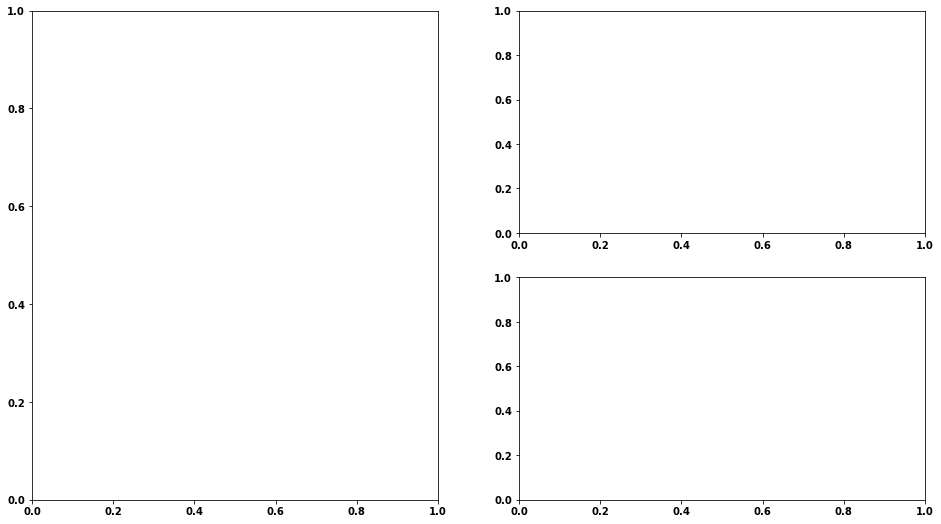

In [38]:
# start the training
autoencoder.train(x_train_new, x_test_new)

Let's see how well the autoencoder performs by compressing the train images and decompress it back

In [ ]:
compressed_data = autoencoder.encode_samples(x_train_new)
decompressed_data = autoencoder.decode_samples(compressed_data)

In [ ]:
vitualize_image(decompressed_data, y_train)

The result seems not bad!

Now let's compress our data for actually training with a QCNN model. 

In [ ]:
x_train_2 = autoencoder.encode_samples(x_train_new).numpy()
x_test_2 = autoencoder.encode_samples(x_test_new).numpy()

In [ ]:
x_train_2_final, x_test_2_final = rescale_data(x_train_2, x_test_2, val_range=(-1, +1))

In [ ]:
# create the QCNN model with the same circuits as before
qcnn = QCNN(encoding_circuit=encoding_circuit, variational_circuit=variational_circuit, lr=5e-3,
            loss='mse', random_state=1)

In [ ]:
# now train with the data compressed with AutoEncoder instead
qcnn.train(x_train_2_final, y_train, batch_size=10, epochs=30)